<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/BADATON/%EC%A7%80%ED%95%98%EC%B2%A0%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%A0%84%EC%B2%B4%EC%8B%9C%EA%B0%84%20%EC%A0%84%ED%9B%8415%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,387 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumBarunGothic'
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

!pip install pyspark
!pip install tslearn

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=54c1f59e61535dbd3404b13ba0415ba8751d3a22a8db5243ed70fc717cb84f69
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 4.5 MB/s eta 0:00:00


# Preprocessing

In [3]:
sub = pd.read_csv('/content/drive/MyDrive/BADA/바다톤/data/바다톤_지하철_일별_지역구별_하차승객수.csv', index_col=0)
sub

,area,하차총승객수
사용일자,,
20221201,강남구,690730
20221201,강서구,235186
20221201,관악구,173855
20221201,노원구,205567
20221201,송파구,329212
...,...,...
20230331,강남구,757252
20230331,강서구,258319
20230331,관악구,192214


In [4]:
sub = sub.reset_index()
sub['사용일자'] = sub['사용일자'].astype(str)
sub['사용일자'] = pd.to_datetime(sub['사용일자'], format='%Y-%m-%d'); sub

,사용일자,area,하차총승객수
0,2022-12-01,강남구,690730
1,2022-12-01,강서구,235186
2,2022-12-01,관악구,173855
3,2022-12-01,노원구,205567
4,2022-12-01,송파구,329212
...,...,...,...
600,2023-03-31,강남구,757252
601,2023-03-31,강서구,258319
602,2023-03-31,관악구,192214
603,2023-03-31,노원구,226710


In [5]:
sub.rename(columns = {'사용일자': 'date', '하차총승객수': 'count'}, inplace=True); sub

,date,area,count
0,2022-12-01,강남구,690730
1,2022-12-01,강서구,235186
2,2022-12-01,관악구,173855
3,2022-12-01,노원구,205567
4,2022-12-01,송파구,329212
...,...,...,...
600,2023-03-31,강남구,757252
601,2023-03-31,강서구,258319
602,2023-03-31,관악구,192214
603,2023-03-31,노원구,226710


In [6]:
#2월 1일 전후 15일로 기간 축소
sub = sub[(sub['date']>=pd.datetime(2023,1,17)) & (sub['date']<=pd.datetime(2023,2,15))]; sub

,date,area,count
235,2023-01-17,강남구,729378
236,2023-01-17,강서구,243540
237,2023-01-17,관악구,180332
238,2023-01-17,노원구,199946
239,2023-01-17,송파구,339342
...,...,...,...
380,2023-02-15,강남구,733089
381,2023-02-15,강서구,249570
382,2023-02-15,관악구,178847
383,2023-02-15,노원구,207435


In [7]:
sub = pd.DataFrame(sub.groupby(['area','date']).sum()['count']); sub

count
area date              
강남구  2023-01-17  729378
     2023-01-18  734795
     2023-01-19  725113
     2023-01-20  654495
     2023-01-21  183634
...                 ...
송파구  2023-02-11  265686
     2023-02-12  192988
     2023-02-13  337191
     2023-02-14  350741
     2023-02-15  349707

[150 rows x 1 columns]

In [8]:
sub = sub.reset_index(level=0); sub

,area,count
date,,
2023-01-17,강남구,729378
2023-01-18,강남구,734795
2023-01-19,강남구,725113
2023-01-20,강남구,654495
2023-01-21,강남구,183634
...,...,...
2023-02-11,송파구,265686
2023-02-12,송파구,192988
2023-02-13,송파구,337191


In [9]:
sub_강남 = sub[sub['area']=='강남구']
sub_강서 = sub[sub['area']=='강서구']
sub_관악 = sub[sub['area']=='관악구']
sub_노원 = sub[sub['area']=='노원구']
sub_송파 = sub[sub['area']=='송파구']

#데이터의 분포 살펴보기

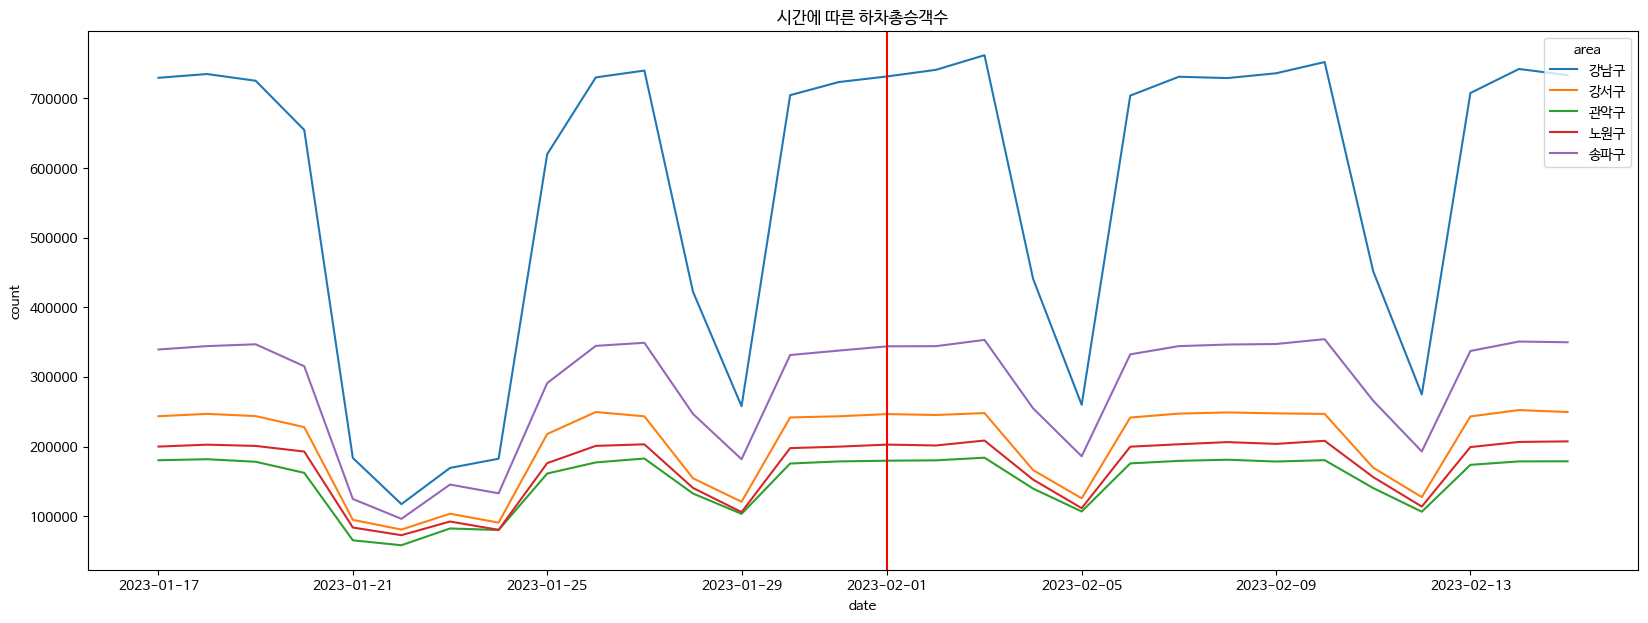

In [10]:
plt.figure(figsize=(20,7))
ax = sns.lineplot(x=sub.index, y=sub['count'], hue=sub['area'])
plt.title('시간에 따른 하차총승객수')
plt.axvline(x=datetime(2023,2,1), ymin=0, ymax=800000, color='red', linestyle='solid')
plt.show()

# stationarity 검정

In [11]:
def adfuller_test(df):
        result = adfuller(df)

        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

        for label, value in zip(labels, result):
            print(label + ' : ' + str(value) )

        if result[1] <= 0.05:
            print('정상성', '\n')
        else:
            print('비정상성', '\n')

In [12]:
adfuller_test(sub_강남['count'])
adfuller_test(sub_강서['count'])
adfuller_test(sub_관악['count'])
adfuller_test(sub_노원['count'])
adfuller_test(sub_송파['count'])

ADF Test Statistic : -3.4137710997571924
p-value : 0.010498278799693825
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -3.1347650824954334
p-value : 0.024085121830916177
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -3.8955134674884224
p-value : 0.002068114744373503
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -3.2331124637254485
p-value : 0.018146244452769508
#Lags Used : 9
Number of Observations Used : 20
정상성 

ADF Test Statistic : -4.527591675466495
p-value : 0.00017525751425023496
#Lags Used : 7
Number of Observations Used : 22
정상성 



다 정상성!

# seasonal_decompose

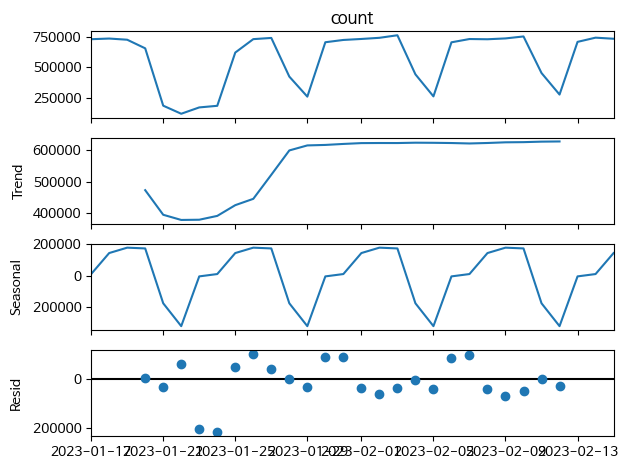

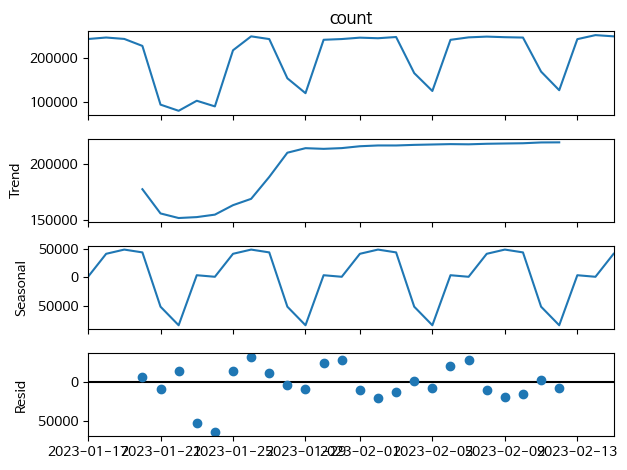

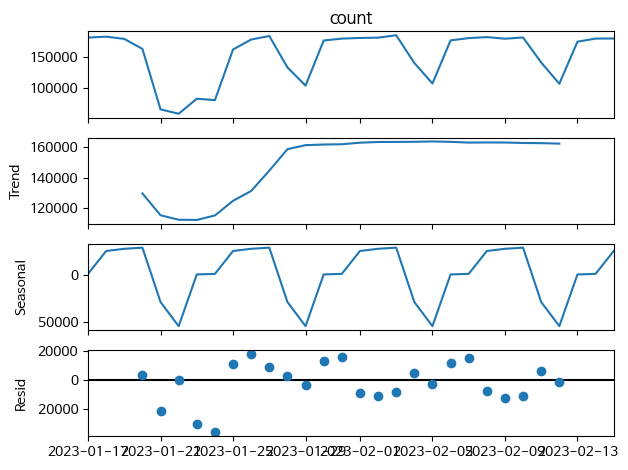

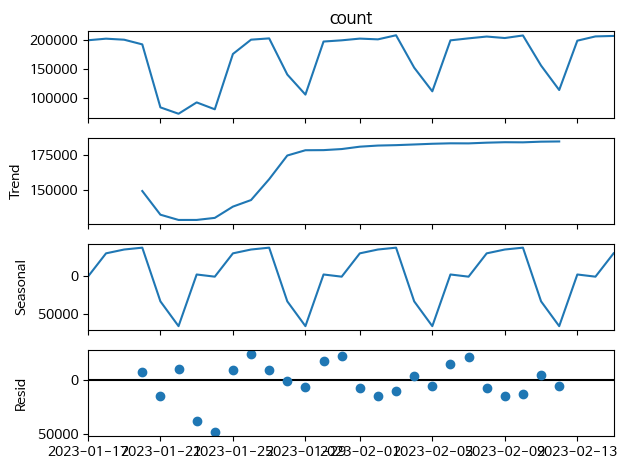

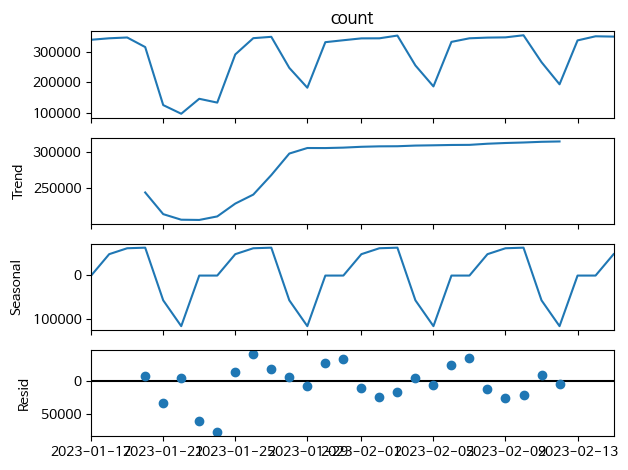

In [13]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    series = df['count']
    result = seasonal_decompose(series, model='additive')
    result.plot()

#ARIMA

SARIMA로 적합했을 때, 데이터 수가 너무 적어서 오히려 AIC가 커짐

In [20]:
def ARIMA(df):

    df.index = pd.DatetimeIndex(df.index.values, freq='D')

    p = list(range(0,2))
    d = [0]
    q = list(range(0,2))
    pdq = list(itertools.product(p, d, q))

    best_aic = np.inf
    best_pdq = None
    tmp_model = None
    best_model = None

    for param in pdq:
        tmp_model = sm.tsa.arima.ARIMA(df['count'], order=param, freq='D')
        result = tmp_model.fit()

        if result.aic < best_aic:
            best_aic = result.aic
            best_pdq = param
            best_model = tmp_model

    print('Best ARIMA {} model >> AIC: {}'.format(best_pdq, best_aic))

    result_optimal = best_model.fit()

    print(result_optimal.summary())

    result_optimal.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()
    print()

    #잔차에 담기
    df['resid'] = result_optimal.resid

Best ARIMA (0, 0, 1) model >> AIC: 815.0806475336899
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -404.540
Date:                Tue, 07 Nov 2023   AIC                            815.081
Time:                        05:34:56   BIC                            819.284
Sample:                    01-17-2023   HQIC                           816.425
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.73e+05   8.23e+04      6.960      0.000    4.12e+05    7.34e+05
ma.L1          0.9566      0.449      2.131      0.033       0.077       1.836

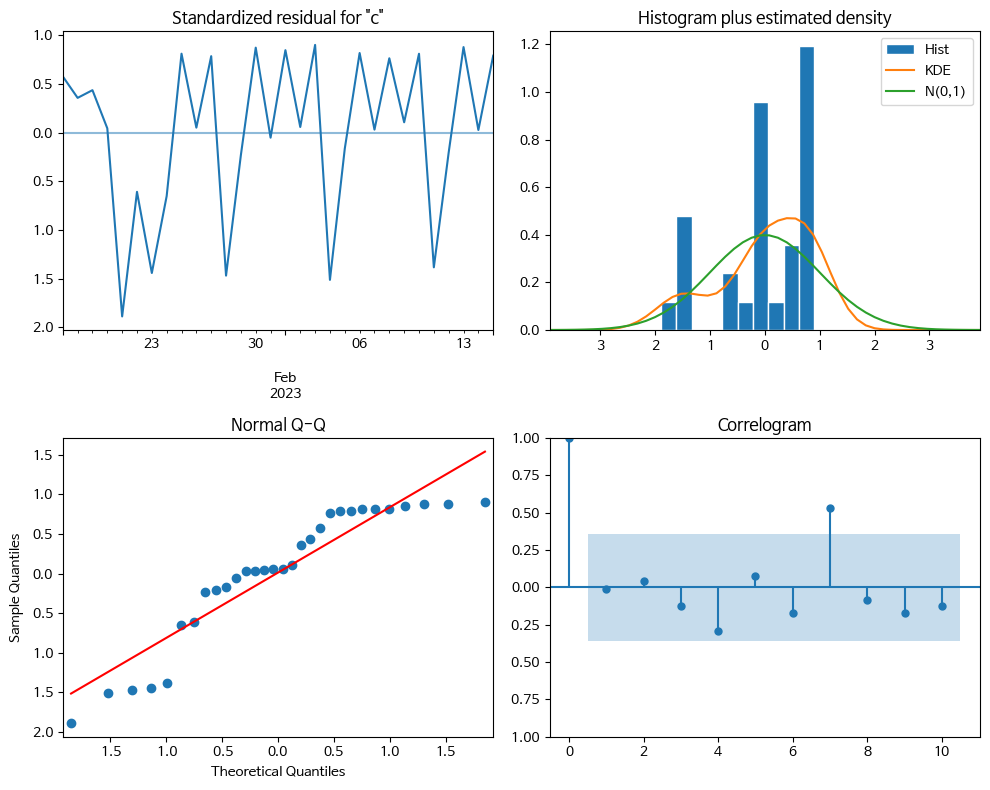

In [21]:
ARIMA(sub_강남)

Best ARIMA (0, 0, 1) model >> AIC: 736.9677904961208
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -365.484
Date:                Tue, 07 Nov 2023   AIC                            736.968
Time:                        05:35:06   BIC                            741.171
Sample:                    01-17-2023   HQIC                           738.313
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.037e+05   2.22e+04      9.168      0.000     1.6e+05    2.47e+05
ma.L1          0.9561      0.410      2.334      0.020       0.153       1.759

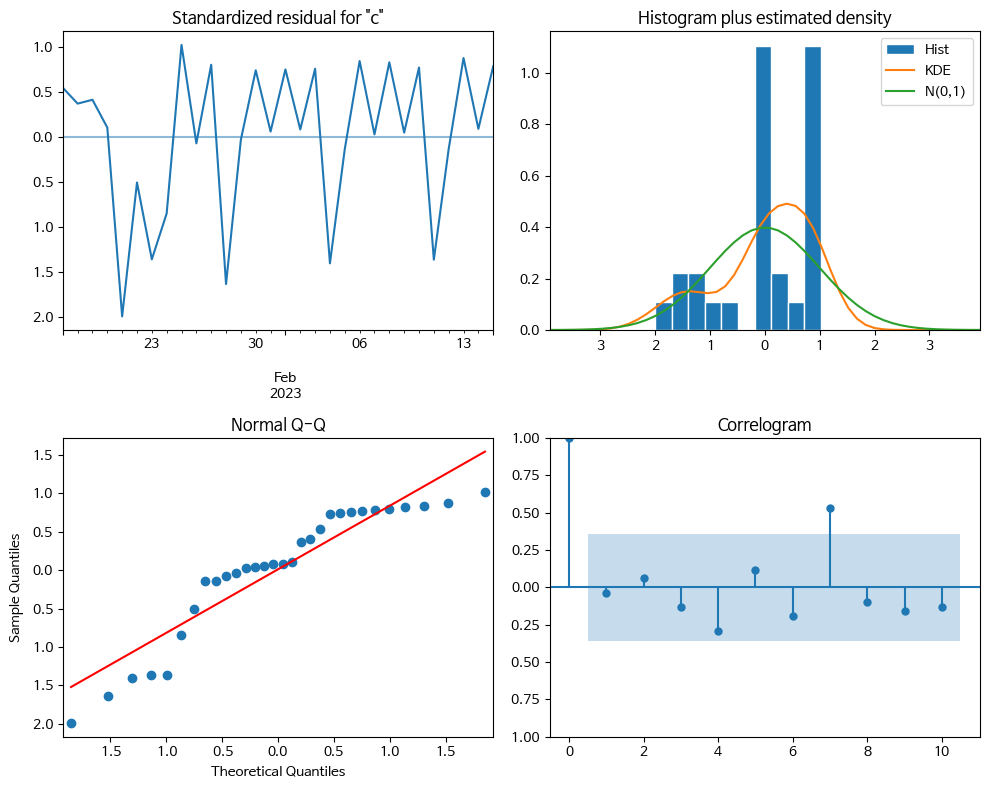

In [22]:
ARIMA(sub_강서)

Best ARIMA (0, 0, 1) model >> AIC: 711.7707573767123
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -352.885
Date:                Tue, 07 Nov 2023   AIC                            711.771
Time:                        05:35:22   BIC                            715.974
Sample:                    01-17-2023   HQIC                           713.116
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+05   1.42e+04     10.746      0.000    1.24e+05     1.8e+05
ma.L1          0.9484      0.287      3.304      0.001       0.386       1.511

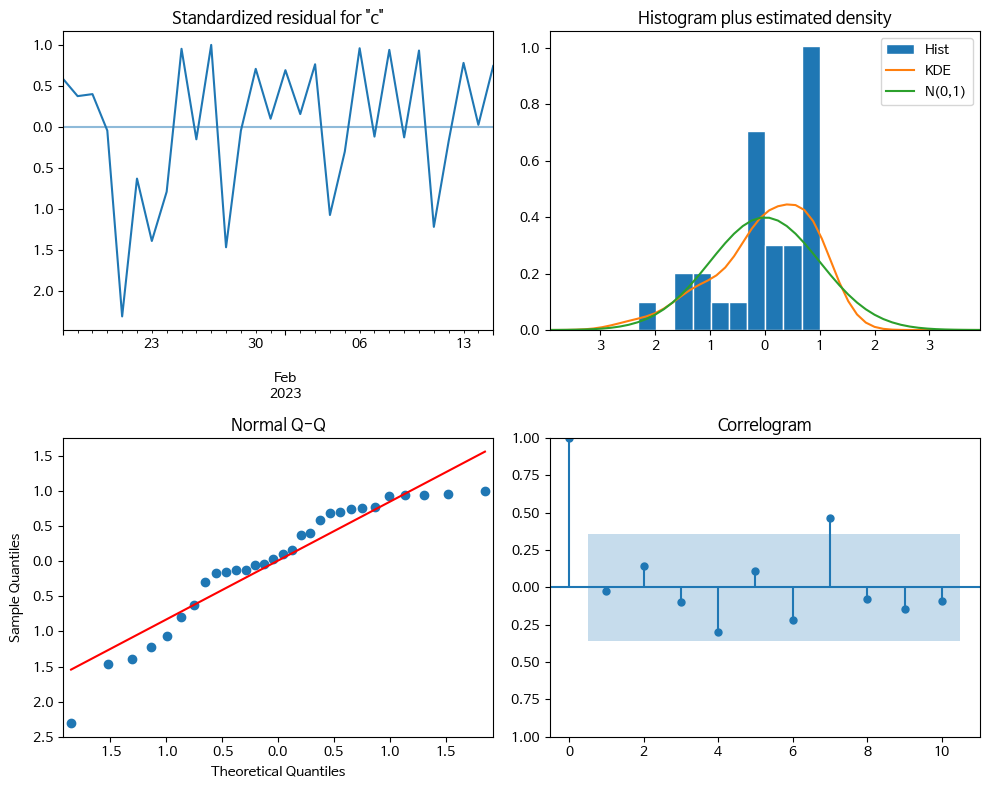

In [23]:
ARIMA(sub_관악)

Best ARIMA (0, 0, 1) model >> AIC: 722.4048484253431
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -358.202
Date:                Tue, 07 Nov 2023   AIC                            722.405
Time:                        05:35:30   BIC                            726.608
Sample:                    01-17-2023   HQIC                           723.750
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.711e+05   1.69e+04     10.119      0.000    1.38e+05    2.04e+05
ma.L1          0.9588      0.374      2.566      0.010       0.226       1.691

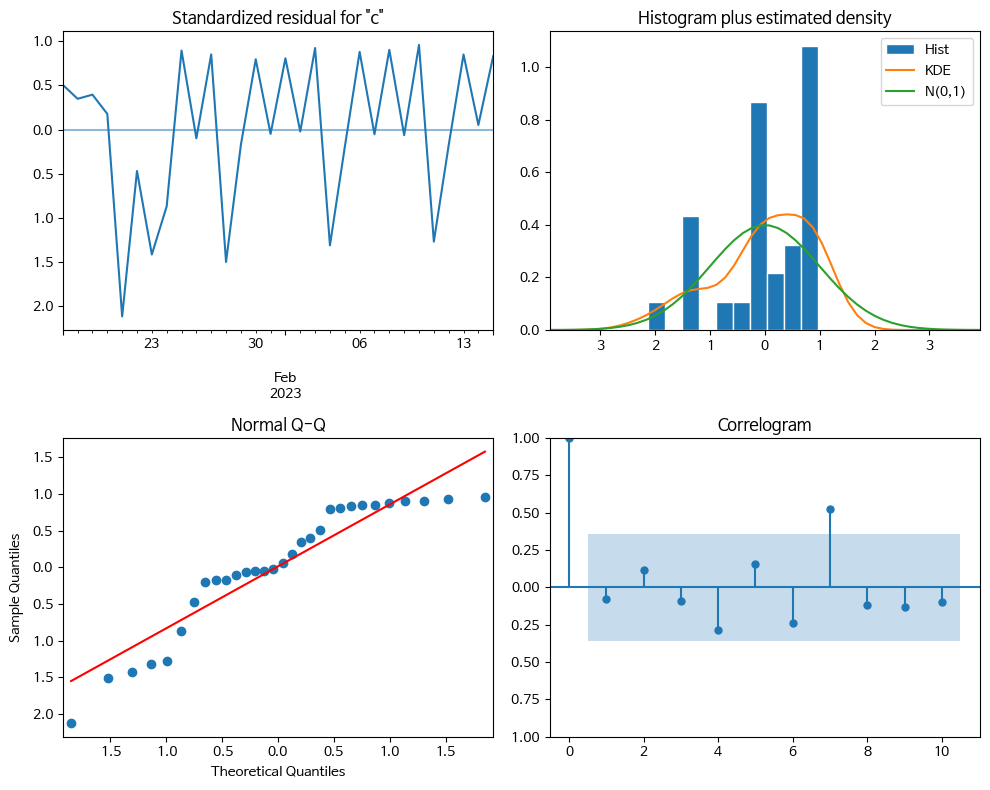

In [24]:
ARIMA(sub_노원)

Best ARIMA (0, 0, 1) model >> AIC: 754.4656764765251
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -374.233
Date:                Tue, 07 Nov 2023   AIC                            754.466
Time:                        05:35:41   BIC                            758.669
Sample:                    01-17-2023   HQIC                           755.810
                         - 02-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.877e+05   2.97e+04      9.682      0.000    2.29e+05    3.46e+05
ma.L1          0.9584      0.404      2.374      0.018       0.167       1.750

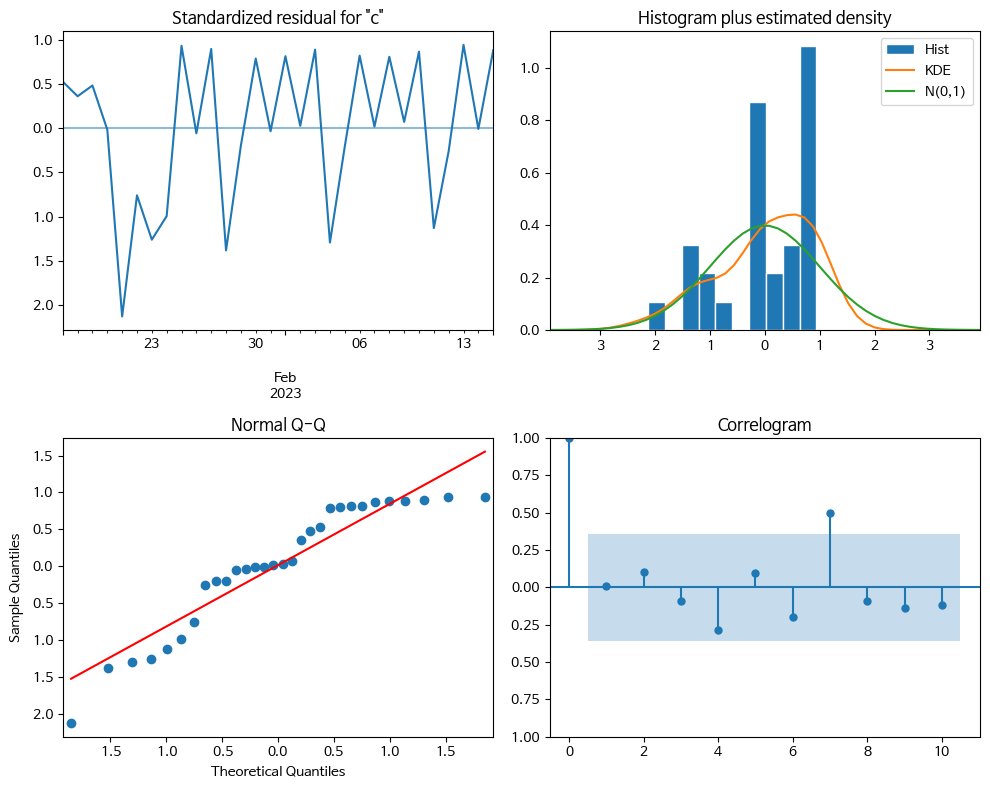

In [25]:
ARIMA(sub_송파)

#표준화잔차

In [26]:
def standardized_residuals(df):
    df['stdresid'] = (df['resid'] - np.mean(df['resid'])) / np.std(df['resid'])
    return df.head()

In [27]:
standardized_residuals(sub_강남)
standardized_residuals(sub_강서)
standardized_residuals(sub_관악)
standardized_residuals(sub_노원)
standardized_residuals(sub_송파)

,area,count,resid,stdresid
2023-01-17,송파구,339342,51679.499664,0.823124
2023-01-18,송파구,344175,30696.084861,0.481308
2023-01-19,송파구,346798,38702.219702,0.611727
2023-01-20,송파구,315315,-1313.111611,-0.040115
2023-01-21,송파구,124695,-161919.848329,-2.656368


In [28]:
sub_강남.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강남_표준화잔차_15.csv')
sub_강서.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_강서_표준화잔차_15.csv')
sub_관악.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_관악_표준화잔차_15.csv')
sub_노원.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_노원_표준화잔차_15.csv')
sub_송파.to_csv('/content/drive/MyDrive/BADA/바다톤/data/sub_송파_표준화잔차_15.csv')

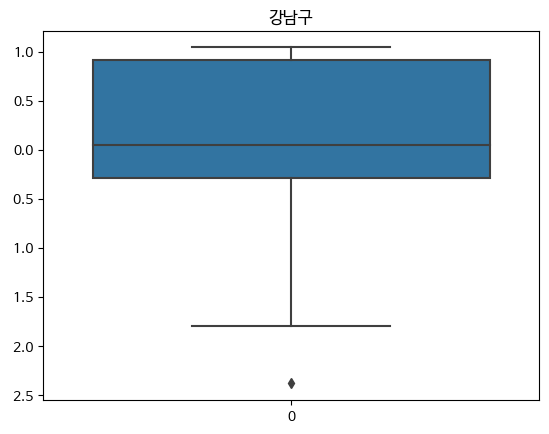

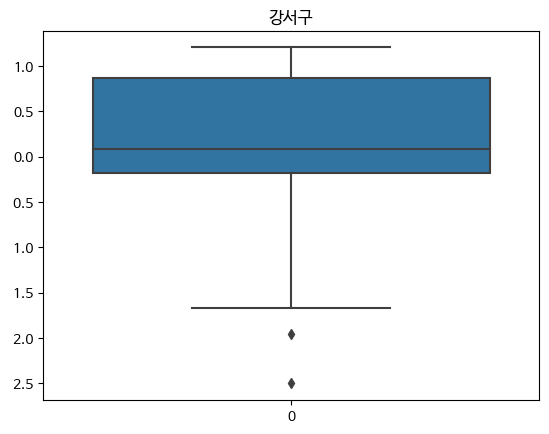

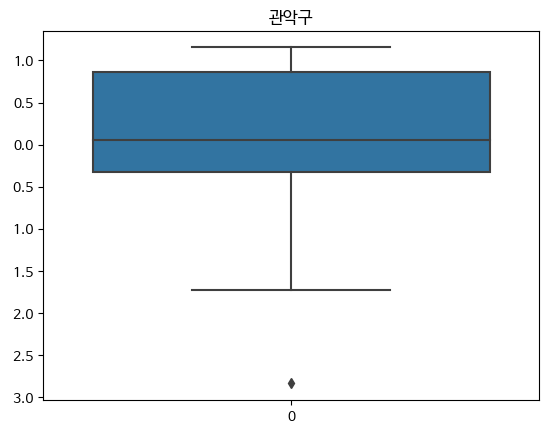

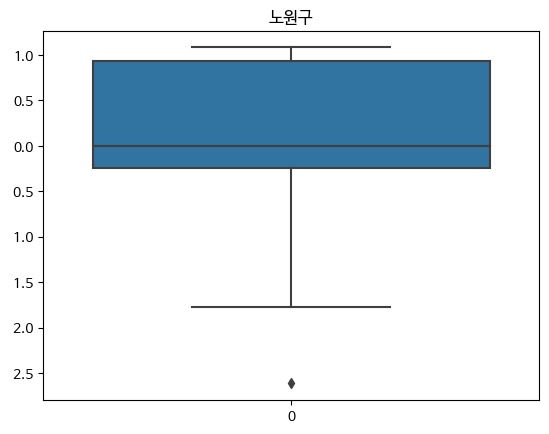

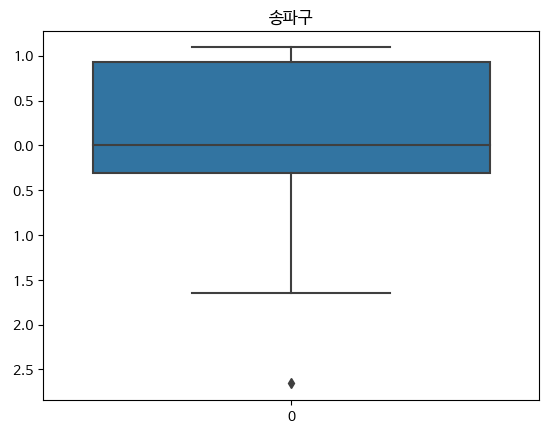

In [29]:
for df in [sub_강남, sub_강서, sub_관악, sub_노원, sub_송파]:
    plt.title(df['area'][0])
    sns.boxplot(df['stdresid'])
    plt.show()

#이상치 탐지

In [30]:
def find_outliers(df):
    outlier_df = pd.DataFrame()
    q3 = df['stdresid'].quantile(0.75)
    q1 = df['stdresid'].quantile(0.25)
    iqr = q3 - q1
    outlier_range = (df['stdresid'] < q1 - 1.5*iqr) | (df['stdresid'] > q3 + 1.5*iqr)
    outlier_df = df['stdresid'].loc[outlier_range]
    print(outlier_df)

In [31]:
find_outliers(sub_강남)

2023-01-21   -2.383745
Freq: D, Name: stdresid, dtype: float64


In [32]:
find_outliers(sub_강서)

2023-01-21   -2.501307
2023-01-28   -1.957028
Freq: 7D, Name: stdresid, dtype: float64


In [33]:
find_outliers(sub_관악)

2023-01-21   -2.837826
Freq: D, Name: stdresid, dtype: float64


In [34]:
find_outliers(sub_노원)

2023-01-21   -2.616066
Freq: D, Name: stdresid, dtype: float64


In [35]:
find_outliers(sub_송파)

2023-01-21   -2.656368
Freq: D, Name: stdresid, dtype: float64


✅ 2월 1일 이후가 없다!